# Hessian Approximation for Toy Models

The idea behind this notebook is to compare the implementations of the various approximations and keep track of all of the results.

In the first part, several sanity checks are performed, which serve to provide a better understanding of the relationships and to ensure the correctness of the code.

The second part then delves deeper into the context and presents different results.

## Sanity Checks

### 1. Linear Regression with 1-D Output for Random Dataset
**Main goal**: Comparing the sklearn regression setup with the JAX Setup

In [ ]:
from config.config import (
    Config,
    ModelConfig,
    RandomRegressionConfig,
    TrainingConfig,
    TrainingConfig,
    get_config,
)
from main import train_and_evaluate


# config = get_config("random_regression_single_feature")
config = Config(
    dataset=RandomRegressionConfig(
        n_samples=100,
        n_features=1,
        n_targets=1,
        noise=30,
        random_state=42,
        train_test_split=1,
    ),
    model=ModelConfig(name="linear", loss="mse"),
    training=TrainingConfig(
        epochs=100,
        lr=0.01,
        optimizer="sgd",
        loss="mse",
    ),
)
model, dataset, params = train_and_evaluate(config)

100%|██████████| 100/100 [00:00<00:00, 741.65it/s]


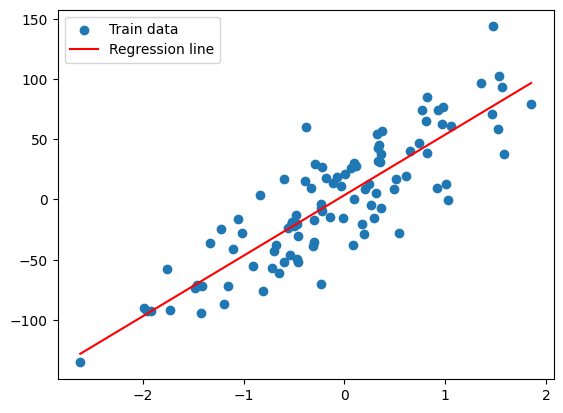

In [ ]:
## Plot results
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import random

x, y = dataset.get_train_data()
x_test = jnp.linspace(jnp.min(x), jnp.max(x), 100).reshape(-1, 1)
y_pred = model.apply(params, x_test)
plt.scatter(x, y, label="Train data")

# make regression line red
plt.plot(x_test, y_pred, color="red", label="Regression line")
plt.legend()
plt.show()


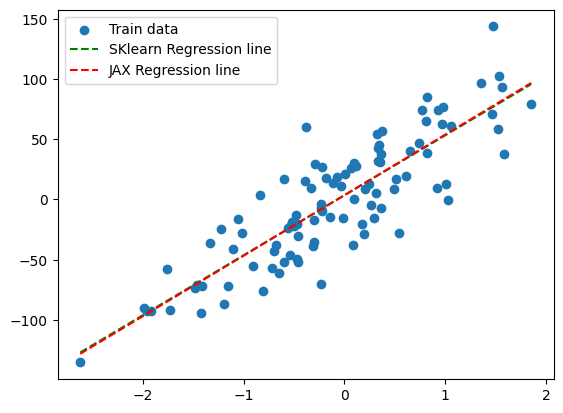

MSE between JAX and SKlearn predictions: 0.38926616311073303


In [ ]:
### Compare with sklearn

from sklearn.linear_model import LinearRegression

sk_model = LinearRegression()
sk_model.fit(np.array(x), np.array(y))
y_sk_pred = sk_model.predict(np.array(x_test))
plt.scatter(x, y, label="Train data")
plt.plot(
    x_test, y_sk_pred, color="green", linestyle="--", label="SKlearn Regression line"
)
plt.plot(x_test, y_pred, color="red", linestyle="--", label="JAX Regression line")
plt.legend()
plt.show()

## Calculate MSE for both models
# The MSE should be very small, close to 0
from sklearn.metrics import mean_squared_error

mse_jax = mean_squared_error(np.array(y_pred), np.array(y_sk_pred))
print(f"MSE between JAX and SKlearn predictions: {mse_jax}")


### 2. Linear Regression on Energy Dataset

**Main goal:** Verify correctness of implementation by comparing the trained regression setting with (exact) sklearn regression implementation, then moving on to the hessian.

For the hessian, we first introduce some notation:
- $H = $ Hessian of a model which is generated by double differentiation using JAX $\texttt{hessian}$ function
- $H_{\text{exact}} = $ Hessian which is computed by some exact formula (only applicable for linear model setting, i.e., linear regression, linear classification)
- $H_{\text{GNH}} = $ Gauss-Newton Hessian ($J^T_{\theta} H_{\text{output}} J_{\theta}$) computed by using JAX differentiation tools

For the Hessian in the regression setting it yields: 
$$ H = H_{GNH} $$

So in the linear setting want to observe that 
$$ || H_{\text{exact}} - H_{GNH} || \approx || H_{\text{exact}} - H || \approx 0 $$

In [ ]:
from config.config import LinearModelConfig, UCIDatasetConfig, get_config
from main import train_and_evaluate


# config = get_config("energy")
config = Config(
    dataset=UCIDatasetConfig(
        name="energy",
        train_test_split=1,
    ),
    model=LinearModelConfig(name="linear", loss="mse", hidden_dim=[]),
    training=TrainingConfig(
        epochs=200,
        lr=0.01,
        batch_size=768,
        optimizer="adam",
        loss="mse",
    ),
)
model_2, dataset_2, params_2 = train_and_evaluate(config)

100%|██████████| 200/200 [00:00<00:00, 309.30it/s]


In [ ]:
## Compare with sklearn
x, y = dataset_2.get_train_data()
y_pred = model_2.apply(params_2, x)

from sklearn.linear_model import LinearRegression

sk_model = LinearRegression()
sk_model.fit(np.array(x), np.array(y))
sk_predictions = sk_model.predict(np.array(x))

## Calculate MSE for both models
# Distance should be very small
from sklearn.metrics import mean_squared_error

mse_jax = mean_squared_error(np.array(y_pred), np.array(sk_predictions))
print(f"MSE between JAX and SKlearn predictions: {mse_jax}")


MSE between JAX and SKlearn predictions: 0.00022414777777157724


#### Hessian Comparison

In [ ]:
# config = get_config("energy")
config_2 = Config(
    dataset=UCIDatasetConfig(
        name="energy",
        train_test_split=1,
    ),
    model=LinearModelConfig(name="linear", loss="mse", hidden_dim=[]),
    training=TrainingConfig(
        epochs=200,
        lr=0.01,
        batch_size=768,
        optimizer="adam",
        loss="mse",
    ),
)
model_2, dataset_2, params_2 = train_and_evaluate(config_2)

config_3 = Config(
    dataset=RandomRegressionConfig(
        n_samples=1000,
        n_features=100,
        n_targets=10,
        noise=20,
        random_state=42,
        train_test_split=1,
    ),
    model=LinearModelConfig(loss="mse", hidden_dim=[]),
    training=TrainingConfig(
        epochs=200,
        lr=0.001,
        batch_size=100,
        optimizer="sgd",
        loss="mse",
    ),
)
model_3, dataset_3, params_3 = train_and_evaluate(config_3)

100%|██████████| 200/200 [00:00<00:00, 248.02it/s]


In [ ]:
from typing import Any
from data.data import AbstractDataset
from hessian_approximations.hessian_approximations import (
    create_hessian_by_name,
    hessian_approximation,
)
from models.base import ApproximationModel
from models.loss import get_loss_fn


def compare_hessians(
    model: ApproximationModel, params: Any, dataset: AbstractDataset, config: Config
):
    exact_hessian_regression = {
        "name": "exact-hessian-regression",
        "create": create_hessian_by_name("exact-hessian-regression"),
    }
    hessian = {"name": "hessian", "create": create_hessian_by_name("hessian")}
    gauss_newton = {
        "name": "gauss-newton",
        "create": create_hessian_by_name("gauss-newton"),
    }

    hessian_approximations = [exact_hessian_regression, hessian, gauss_newton]
    hessian_results = {}

    for hessian_approx in hessian_approximations:
        hessian_matrix = hessian_approximation(
            method=hessian_approx["create"],
            model=model,
            parameters=params,
            test_data=jnp.asarray(dataset.get_train_data()[0]),
            test_targets=jnp.asarray(dataset.get_train_data()[1]),
            loss=get_loss_fn(config.model.loss),
        )

        hessian_results[hessian_approx["name"]] = hessian_matrix

    # Compare the Hessian matrices
    for i in range(len(hessian_results)):
        for j in range(i + 1, len(hessian_results)):
            matrix_diff = (
                hessian_results[hessian_approximations[i]["name"]]
                - hessian_results[hessian_approximations[j]["name"]]
            )
            diff = jnp.linalg.norm(matrix_diff, "fro")
            print(
                f"Difference between {hessian_approximations[i]['name']} and {hessian_approximations[j]['name']} for Frobenius norm: {diff}"
            )

    print("----")
    # Search for max different entries
    for i in range(len(hessian_results)):
        for j in range(i + 1, len(hessian_results)):
            matrix_diff = (
                hessian_results[hessian_approximations[i]["name"]]
                - hessian_results[hessian_approximations[j]["name"]]
            )
            max_diff = jnp.max(jnp.abs(matrix_diff))
            print(
                f"Max absolute difference between {hessian_approximations[i]['name']} and {hessian_approximations[j]['name']}: {max_diff}"
            )


print("Results for Energy dataset:")
compare_hessians(model_2, params_2, dataset_2, config_2)
print("======")
print("Results for Random Regression dataset:")
compare_hessians(model_3, params_3, dataset_3, config_3)

Results for Energy dataset:
Difference between exact-hessian-regression and hessian for Frobenius norm: 7.530441507697105e-06
Difference between exact-hessian-regression and gauss-newton for Frobenius norm: 4.943704425386386e-06
Difference between hessian and gauss-newton for Frobenius norm: 5.671045073540881e-06
----
Max absolute difference between exact-hessian-regression and hessian: 2.5033950805664062e-06
Max absolute difference between exact-hessian-regression and gauss-newton: 2.086162567138672e-06
Max absolute difference between hessian and gauss-newton: 2.0265579223632812e-06
Results for Random Regression dataset:
Difference between exact-hessian-regression and hessian for Frobenius norm: 2.3773561679263366e-06
Difference between exact-hessian-regression and gauss-newton for Frobenius norm: 2.5046736027434235e-06
Difference between hessian and gauss-newton for Frobenius norm: 2.4115499854815425e-06
----
Max absolute difference between exact-hessian-regression and hessian: 4.768